# S&DS 431/631 Optimization and Computation 
## Final Project Demo
## Name: Tatsuhiro Shimizu

[GitHub Repository](https://github.com/tatsu432/in-context-learning)

# 0.1 Environment Settings
To run the code without any error correctly, I would recommend that you use the following dependencies:
```
  - pip=21.2.4
  - python=3.8.12
  - pytorch=1.11.0
  - pip:
    - jupyter==1.0.0
    - matplotlib==3.5.2
    - numpy==1.22.3
    - pandas==1.4.2
    - quinine==0.3.0
    - scikit-learn==1.0.2
    - seaborn==0.11.2
    - tqdm==4.64.0
    - transformers==4.17.0
    - wandb==0.12.11
    - xgboost==1.6.1
    - protobuf==3.20.1
```



In [ ]:
# # Please Uncomment if you have not installed the following packages
# !pip install transformers==4.17.0
# !pip install munch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 21.4 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.46.3
    Uninstalling transformers-4.46.3:
      Successfully uninstalled transformers-4.46.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sentence-transformers 3.2.1 requires transformers<5.0.0,>=4.41.0, but you have transformers 4.17.0 which is incompatible.


# 0.2 Current Directory Setting
Please kindly set ```in-context-learning/src``` the current directory.




In [ ]:
# # This is the direcotry sturcture on my Google Drive. I would appreciate it if you could change it to yours correctly to run the code
# from google.colab import drive
# drive.mount('/content/drive')

# project_path = '/content/drive/My\ Drive/Colab\ Notebooks/Yale/fall2024/sds631/project/in-context-learning/src'
# !ls {project_path}

# %cd /content/drive/My Drive/Colab Notebooks/Yale/fall2024/sds631/project/in-context-learning/src

Mounted at /content/drive


# 0.3 Import the packages

In [ ]:
from collections import OrderedDict
import re
import os
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm
from eval import get_run_metrics, read_run_dir, get_model_from_run, eval_model
from plot_utils import basic_plot, collect_results, relevant_model_names
from samplers import get_data_sampler
from tasks import get_task_sampler

%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')
run_dir = "../models"

# 0.4 Define the task and the path to which the pretrained parameters are stored

In [ ]:
# Defined the task name
task_linear_regression = "linear_regression"
task_sparse_linear_regression = "sparse_linear_regression"
task_decision_tree = "decision_tree"
task_2nn = "relu_2nn_regression"

# Define the run_id to fetch the already computed parameters
run_id = "pretrained"

# Define the path we use to collect the pretrained parameter
run_path_linear = os.path.join(run_dir, task_linear_regression, run_id)
run_path_sparse_linear = os.path.join(run_dir, task_sparse_linear_regression, run_id)
run_path_tree = os.path.join(run_dir, task_decision_tree, run_id)
run_path_2nn = os.path.join(run_dir, task_2nn, run_id)

# 1. Transformer pretrained on the linear regression task
In this section, we are going to achieve the following:

*   Reproduce the experimental results on the ability of the transformer pretrained on the **linear regression task** to do in-context learning on the same task
*   Conduct an original experiment to check the ability of the transformer pretrained on the **linear regression task** to do in-context learning on the logistic regression task under the following three cases

    1.   standard logistic regression task
    2.   noisy logistic regression task
    3.   noisy stochastic logistic regression task


## 1.1 Load the transformer model
We load the transformer model pretrained on the **linear regression task**
*   n_dims: the dimension of each input is $20$
*   batch_size: the batchsize is $64 \times 10$

In [ ]:
model_tf_linear, conf_linear = get_model_from_run(run_path_linear)

n_dims = conf_linear.model.n_dims
batch_size = conf_linear.training.batch_size * 10

/content/drive/My Drive/Colab Notebooks/Yale/fall2024/sds631/project/in-context-learning/src/eval.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(sta

## 1.2 Define the task
We define the task used for the pretraining.
*   data_sampler: the sampler to sample the input data $x$
*   task_sampler: the sampler to sample the task data $f(x)$

In [ ]:
data_sampler = get_data_sampler(conf_linear.training.data, n_dims)
task_sampler = get_task_sampler(
    conf_linear.training.task,
    n_dims,\
    batch_size,
    **conf_linear.training.task_kwargs
)
task = task_sampler()

## 1.3 In-context learning the **linear regression task**
We do the following process for each prompt in the batch
* We generate the prompt $P := (x_1, f(x_1), \cdots, x_k, f(x_k), x_{\text{querry}}, f(x_{\text{querry}}))$
  *   xs: the input data $\{x_1, \cdots, x_k, x_{\text{querry}}\}$
  *   ys: the label data $\{f(x_1), \cdots, f(x_k), f(x_{\text{querry}})\}$
  * $x_i, x_{\text{querry}} \overset{iid}{\sim} N(0, I_d) \quad \forall i \in [k]$
  * $f(x) := w^\top x$ where $w \sim N(0, I_d)$
  * $d = 20$ is the dimension of the input $x \in \mathbb{R}^d$
* We obtain the values $M(P^i)$ predicted by the transformer model $M$ given the $i$-th prompt $P^i := (x_1, f(x_1), \cdots, x_i, f(x_i), x_{i + 1})$ for each $i = 0, 1, \cdots, k$
* We compute the loss $\ell(M(P^i), f(x_{i + 1})) = (M(P^i) - f(x_{i + 1}))^2$ for each $i = 0, 1, \cdots, k$

In [ ]:
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf_linear.training.curriculum.points.end)
ys = task.evaluate(xs)

with torch.no_grad():
    pred_linear = model_tf_linear(xs, ys)

metric = task.get_metric()
loss_linear = metric(pred_linear, ys).numpy()

## 1.4 In-context learning the **linear regression task with doubled input**
We conduct the same process as in 1.3 except for the following where we consider the doubled input
  *   xs2: the input data $\{x_1, \cdots, x_k, x_{\text{querry}}\}$
  *   ys2: the label data $\{f(x_1), \cdots, f(x_k), f(x_{\text{querry}})\}$
  * $x_i, x_{\text{querry}} \overset{iid}{\sim} N(0, 2^2 \cdot I_d) \quad \forall i \in [k]$

In [ ]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)

with torch.no_grad():
    pred2_linear = model_tf_linear(xs2, ys2)

loss2_linear = metric(pred2_linear, ys2).numpy()

## 1.5 In-context learning the **logistic regression task**
We conduct the same process as in 1.3 except for the following where we consider the logistirc rergession as a task
*   xs_logreg: the input data $\{x_1, \cdots, x_k, x_{\text{querry}}\}$
*   ys_logreg: the label data $\{f(x_1), \cdots, f(x_k), f(x_{\text{querry}})\}$
* $f(x) := 1\left\{\frac{1}{1 + \exp\left[- 1_d^\top x\right]} \ge \frac{1}{2} \right\}$

In [ ]:
xs_logreg = xs
ys_logreg = xs_logreg.sum(axis=2)
ys_logreg = torch.sigmoid(ys_logreg)
ys_logreg = (ys_logreg >= 0.5).float()

with torch.no_grad():
    pred_logreg_linear = model_tf_linear(xs_logreg, ys_logreg)

loss_logreg_linear = metric(pred_logreg_linear, ys_logreg).numpy()

## 1.6 In-context learning the **noisy logistic regression task**
We conduct the same process as in 1.3 except for the following where we consider the noisy logistirc rergession as a task
*   xs_logreg_noised: the input data $\{x_1, \cdots, x_k, x_{\text{querry}}\}$
*   ys_logreg_noised: the label data $\{f(x_1), \cdots, f(x_k), f(x_{\text{querry}})\}$
* $f(x) := 1\left\{\frac{1}{1 + \exp\left[- 1_d^\top x + \epsilon\right]} \ge \frac{1}{2} \right\}$ where $\epsilon \sim N(0, 1)$

In [ ]:
xs_logreg_noised = xs
ys_logreg_noised = xs_logreg.sum(axis=2)
noise = torch.randn_like(ys_logreg_noised)
ys_logreg_noised = ys_logreg_noised + noise
ys_logreg_noised = torch.sigmoid(ys_logreg_noised)
ys_logreg_noised = (ys_logreg_noised >= 0.5).float()

with torch.no_grad():
    pred_logreg_noised_linear = model_tf_linear(xs_logreg_noised, ys_logreg_noised)

loss_logreg_noised_linear = metric(pred_logreg_noised_linear, ys_logreg_noised).numpy()

## 1.7 In-context learning the **stochastic noisy logistic regression task**
We conduct the same process as in 1.3 except for the following where we consider the noisy logistirc rergession as a task where the label is sampled from the Bernulli distribution
*   xs_logreg_noised_stochastic: the input data $\{x_1, \cdots, x_k, x_{\text{querry}}\}$
*   ys_logreg_noised_stochastic: the label data $\{f(x_1), \cdots, f(x_k), f(x_{\text{querry}})\}$
* $f(x) \sim \text{Bern}\left(\frac{1}{1 + \exp\left[- 1_d^\top x + \epsilon\right]}\right)$ where $\epsilon \sim N(0, 1)$

In [ ]:
xs_logreg_noised_stochastic = xs
ys_logreg_noised_stochastic = xs_logreg.sum(axis=2)
noise = torch.randn_like(ys_logreg_noised_stochastic)
ys_logreg_noised_stochastic = ys_logreg_noised_stochastic + noise
ys_logreg_noised_stochastic = torch.sigmoid(ys_logreg_noised_stochastic)
ys_logreg_noised_stochastic = torch.bernoulli(ys_logreg_noised_stochastic).float()

with torch.no_grad():
    pred_logreg_noised_stochastic_linear = model_tf_linear(xs_logreg_noised_stochastic, ys_logreg_noised_stochastic)

loss_logreg_noised_stochastic_linear = metric(pred_logreg_noised_stochastic_linear, ys_logreg_noised_stochastic).numpy()

# 1.8 Visualize the performance of the transformer's in-context learning ability
Interpretation of the results
*   The transformer model pretrained on the linear regression task fails to effectively in-context learn a logistic regression probably because the logistic regression is more general problem compared to the multiple linear regression
*   We observe the double descent error curve for each logistic regression task particularly around the size of in-context examples is $20$, which is same as the dimension $d$ of the input $x$
*   We also observe that the transformer pretrained on the linear regression task has worse performance when we consider the stochastic noisy and noisy logistic regression tasks compared to the standard logistic regression task with in-context examples larger than $20$

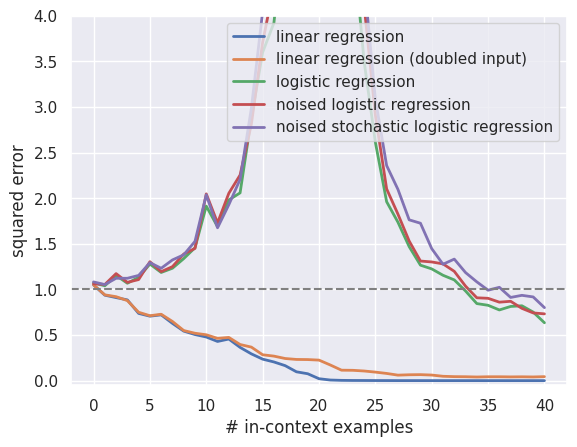

In [ ]:
sparsity = conf_linear.training.task_kwargs.sparsity if "sparsity" in conf_linear.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf_linear.training.task]
plt.plot(loss_linear.mean(axis=0) / n_dims, lw=2, label="linear regression")
plt.plot(loss2_linear.mean(axis=0) / 4 / n_dims, lw=2, label="linear regression (doubled input)")
plt.plot(loss_logreg_linear.mean(axis=0) / 0.5, lw=2, label="logistic regression")
plt.plot(loss_logreg_noised_linear.mean(axis=0) / 0.5, lw=2, label="noised logistic regression")
plt.plot(loss_logreg_noised_stochastic_linear.mean(axis=0) / 0.5, lw=2, label="noised stochastic logistic regression")
plt.axhline(baseline / n_dims, ls="--", color="gray")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.ylim(-0.05, 4)  # Replace 0 and 1 with your desired y-axis limits
plt.legend()
plt.show()

# 2. Transformer pretrained on the sparse linear regression task
In this section, we are going to achieve the following:

*   Reproduce the experimental results on the ability of the transformer pretrained on the **sparse linear regression task** to do in-context learning on the same task
*   Conduct an original experiment to check the ability of the transformer pretrained on the **sparse linear regression task** to do in-context learning on the logistic regression task under the following three cases
    1.   standard logistic regression task
    2.   noisy logistic regression task
    3.   noisy stochastic logistic regression task

## 2.1 Load the transformer model
We load the transformer model pretrained on the **sparse linear regression task**

*   n_dims: the dimension of each input is $20$
*   batch_size: the batchsize is $64 \times 10$

In [ ]:
model_tf_sparse_linear, conf_sparse_linear = get_model_from_run(run_path_sparse_linear)

n_dims = conf_sparse_linear.model.n_dims
batch_size = conf_sparse_linear.training.batch_size * 10

## 2.2 Define the task
We define the task used for the pretraining.

*   data_sampler: the sampler to sample the input data $x$
*   task_sampler: the sampler to sample the task data $f(x)$

In [ ]:
data_sampler = get_data_sampler(conf_sparse_linear.training.data, n_dims)
task_sampler = get_task_sampler(
    conf_sparse_linear.training.task,
    n_dims,\
    batch_size,
    **conf_sparse_linear.training.task_kwargs
)
task = task_sampler()

## 2.3 In-context learning the **sparse linear regression task**
We do the following process for each prompt in the batch
* We generate the prompt $P := (x_1, f(x_1), \cdots, x_k, f(x_k), x_{\text{querry}}, f(x_{\text{querry}}))$
  *   xs: the input data $\{x_1, \cdots, x_k, x_{\text{querry}}\}$
  *   ys: the label data $\{f(x_1), \cdots, f(x_k), f(x_{\text{querry}})\}$
  * $x_i, x_{\text{querry}} \overset{iid}{\sim} N(0, I_d) \quad \forall i \in [k]$
  * $f(x) := w^\top x$ where $w \sim N(0, I_d)$ and then zero out $d-s = 17$ coordinates of $w$ uniformly random to construct a sparsity
  * $s = 3$ is the number of the meaningul coordinates in $w$, capturing how sparse it is
  * $d = 20$ is the dimension of the input $x \in \mathbb{R}^d$
* We obtain the values $M(P^i)$ predicted by the transformer model $M$ given the $i$-th prompt $P^i := (x_1, f(x_1), \cdots, x_i, f(x_i), x_{i + 1})$ for each $i = 0, 1, \cdots, k$
* We compute the loss $\ell(M(P^i), f(x_{i + 1})) = (M(P^i) - f(x_{i + 1}))^2$ for each $i = 0, 1, \cdots, k$

In [ ]:
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf_sparse_linear.training.curriculum.points.end)
ys = task.evaluate(xs)

with torch.no_grad():
    pred_sparse_linear = model_tf_sparse_linear(xs, ys)

metric = task.get_metric()
loss_sparse_linear = metric(pred_sparse_linear, ys).numpy()

## 2.4 In-context learning the **sparse linear regression task with doubled input**
We conduct the same process as in 2.3 except for the following where we consider the doubled input
  *   xs2: the input data $\{x_1, \cdots, x_k, x_{\text{querry}}\}$
  *   ys2: the label data $\{f(x_1), \cdots, f(x_k), f(x_{\text{querry}})\}$
  * $x_i, x_{\text{querry}} \overset{iid}{\sim} N(0, 2^2 \cdot I_d) \quad \forall i \in [k]$

In [ ]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)

with torch.no_grad():
    pred2_sparse_linear = model_tf_sparse_linear(xs2, ys2)

loss2_sparse_linear = metric(pred2_sparse_linear, ys2).numpy()

## 2.5 In-context learning the **sparse logistic regression task**
We conduct the same process as in 2.3 except for the following where we consider the logistirc rergession as a task
*   xs_logreg: the input data $\{x_1, \cdots, x_k, x_{\text{querry}}\}$
*   ys_logreg: the label data $\{f(x_1), \cdots, f(x_k), f(x_{\text{querry}})\}$
* $f(x) := 1\left\{\frac{1}{1 + \exp\left[- 1_d^\top x\right]} \ge \frac{1}{2} \right\}$

In [ ]:
xs_logreg = xs
ys_logreg = xs_logreg.sum(axis=2)
ys_logreg = torch.sigmoid(ys_logreg)
ys_logreg = (ys_logreg >= 0.5).float()

with torch.no_grad():
    pred_logreg_sparse_linear = model_tf_sparse_linear(xs_logreg, ys_logreg)

loss_logreg_sparse_linear = metric(pred_logreg_sparse_linear, ys_logreg).numpy()

## 2.6 In-context learning the **noisy logistic regression task**
We conduct the same process as in 2.3 except for the following where we consider the noisy logistirc rergession as a task
*   xs_logreg_noised: the input data $\{x_1, \cdots, x_k, x_{\text{querry}}\}$
*   ys_logreg_noised: the label data $\{f(x_1), \cdots, f(x_k), f(x_{\text{querry}})\}$
* $f(x) := 1\left\{\frac{1}{1 + \exp\left[- 1_d^\top x + \epsilon\right]} \ge \frac{1}{2} \right\}$ where $\epsilon \sim N(0, 1)$

In [ ]:
xs_logreg_noised = xs
ys_logreg_noised = xs_logreg.sum(axis=2)
noise = torch.randn_like(ys_logreg_noised)
ys_logreg_noised = ys_logreg_noised + noise
ys_logreg_noised = torch.sigmoid(ys_logreg_noised)
ys_logreg_noised = (ys_logreg_noised >= 0.5).float()

with torch.no_grad():
    pred_logreg_noised_sparse_linear = model_tf_sparse_linear(xs_logreg_noised, ys_logreg_noised)

loss_logreg_noised_sparse_linear = metric(pred_logreg_noised_sparse_linear, ys_logreg_noised).numpy()

## 2.7 In-context learning the **stochastic noisy logistic regression task**
We conduct the same process as in 2.3 except for the following where we consider the noisy logistirc rergession as a task where the label is sampled from the Bernulli distribution
*   xs_logreg_noised_stochastic: the input data $\{x_1, \cdots, x_k, x_{\text{querry}}\}$
*   ys_logreg_noised_stochastic: the label data $\{f(x_1), \cdots, f(x_k), f(x_{\text{querry}})\}$
* $f(x) \sim \text{Bern}\left(\frac{1}{1 + \exp\left[- 1_d^\top x + \epsilon\right]}\right)$ where $\epsilon \sim N(0, 1)$

In [ ]:
xs_logreg_noised_stochastic = xs
ys_logreg_noised_stochastic = xs_logreg.sum(axis=2)
noise = torch.randn_like(ys_logreg_noised_stochastic)
ys_logreg_noised_stochastic = ys_logreg_noised_stochastic + noise
ys_logreg_noised_stochastic = torch.sigmoid(ys_logreg_noised_stochastic)
ys_logreg_noised_stochastic = torch.bernoulli(ys_logreg_noised_stochastic).float()

with torch.no_grad():
    pred_logreg_noised_stochastic_sparse_linear = model_tf_sparse_linear(xs_logreg_noised_stochastic, ys_logreg_noised_stochastic)

loss_logreg_noised_stochastic_sparse_linear = metric(pred_logreg_noised_stochastic_sparse_linear, ys_logreg_noised_stochastic).numpy()

# 2.8 Visualize the performance of the transformer's in-context learning ability
Interpretation of the results
*   The in-context learning ability of the transformer model pretrained on the sparse linear regression task is not affected so much by the scale of the input compared to the one pretrained on the standard linear regression
*   The transformer model pretrained on the sparse linear regression task fails to effectively in-context learn a logistic regression probably probably due to the same reason as the one on the standard linear regression task
*   Same as the result of the transformer pretrained on the linear regression task, we observe the double descent error curve
*   We also observe that the transformer pretrained on the linear regression task has worse performance when we consider the stochastic noisy and noisy logistic regression tasks compared to the standard logistic regression task with in-context examples larger than $20$

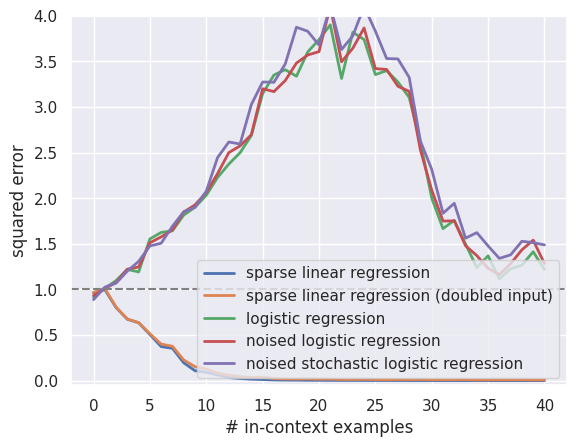

In [ ]:
sparsity = conf_sparse_linear.training.task_kwargs.sparsity if "sparsity" in conf_sparse_linear.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf_sparse_linear.training.task]
plt.plot(loss_sparse_linear.mean(axis=0) / sparsity, lw=2, label="sparse linear regression")
plt.plot(loss2_sparse_linear.mean(axis=0) / 4 / sparsity, lw=2, label="sparse linear regression (doubled input)")
plt.plot(loss_logreg_sparse_linear.mean(axis=0) / 0.5, lw=2, label="logistic regression")
plt.plot(loss_logreg_noised_sparse_linear.mean(axis=0) / 0.5, lw=2, label="noised logistic regression")
plt.plot(loss_logreg_noised_stochastic_sparse_linear.mean(axis=0) / 0.5, lw=2, label="noised stochastic logistic regression")
plt.axhline(baseline / sparsity, ls="--", color="gray")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.ylim(-0.05, 4)  # Replace 0 and 1 with your desired y-axis limits
plt.legend()
plt.show()

# 3. Transformer pretrained on the decision tree task
In this section, we are going to achieve the following:

*   Reproduce the experimental results on the ability of the transformer pretrained on the **decision tree task** to do in-context learning on the same task
*   Conduct an original experiment to check the ability of the transformer pretrained on the **decision tree task** to do in-context learning on the logistic regression task under the following three cases
    1.   standard logistic regression task
    2.   noisy logistic regression task
    3.   noisy stochastic logistic regression task

## 3.1 Load the transformer model
We load the transformer model pretrained on the **decision tree task**

*   n_dims: the dimension of each input is $20$
*   batch_size: the batchsize is $64 \times 10$

In [ ]:
model_tf_tree, conf_tree = get_model_from_run(run_path_tree)

n_dims = conf_tree.model.n_dims
batch_size = conf_tree.training.batch_size * 10

## 3.2 Define the task
We define the task used for the pretraining.
*   data_sampler: the sampler to sample the input data $x$
*   task_sampler: the sampler to sample the task data $f(x)$

In [ ]:
data_sampler = get_data_sampler(conf_tree.training.data, n_dims)
task_sampler = get_task_sampler(
    conf_tree.training.task,
    n_dims,\
    batch_size,
    **conf_tree.training.task_kwargs
)
task = task_sampler()

## 3.3 In-context learning the **decision tree task**
We do the following process for each prompt in the batch
* We generate the prompt $P := (x_1, f(x_1), \cdots, x_k, f(x_k), x_{\text{querry}}, f(x_{\text{querry}}))$
  *   xs: the input data $\{x_1, \cdots, x_k, x_{\text{querry}}\}$
  *   ys: the label data $\{f(x_1), \cdots, f(x_k), f(x_{\text{querry}})\}$
  * $x_i, x_{\text{querry}} \overset{iid}{\sim} N(0, I_d) \quad \forall i \in [k]$
  * $f(x)$ is the corresponding value of the leaf achieved by following the complete binary tree with depth $4$ where each leaf is sampled from $N(0, 1)$
  * We evalute $f(x)$ by following the tree where we follow the right child node if the value of the $k$-th dimension of the input $x$ is positive and follow the left child otherwise. The non-leaf nodes are uniformly sampled from $\text{Unif}(1, 2, \cdots, d)$
  * $d = 20$ is the dimension of the input $x \in \mathbb{R}^d$
* We obtain the values $M(P^i)$ predicted by the transformer model $M$ given the $i$-th prompt $P^i := (x_1, f(x_1), \cdots, x_i, f(x_i), x_{i + 1})$ for each $i = 0, 1, \cdots, k$
* We compute the loss $\ell(M(P^i), f(x_{i + 1})) = (M(P^i) - f(x_{i + 1}))^2$ for each $i = 0, 1, \cdots, k$

In [ ]:
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf_tree.training.curriculum.points.end)
ys = task.evaluate(xs)

with torch.no_grad():
    pred_tree = model_tf_tree(xs, ys)

metric = task.get_metric()
loss_tree = metric(pred_tree, ys).numpy()

## 3.4 In-context learning the **decision tree task with doubled input**
We conduct the same process as in 3.3 except for the following where we consider the doubled input
  *   xs2: the input data $\{x_1, \cdots, x_k, x_{\text{querry}}\}$
  *   ys2: the label data $\{f(x_1), \cdots, f(x_k), f(x_{\text{querry}})\}$
  * $x_i, x_{\text{querry}} \overset{iid}{\sim} N(0, 2^2 \cdot I_d) \quad \forall i \in [k]$

In [ ]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)

with torch.no_grad():
    pred2_tree = model_tf_tree(xs2, ys2)

loss2_tree = metric(pred2_tree, ys2).numpy()

## 3.5 In-context learning the **logistirc rergession task**
We conduct the same process as in 3.3 except for the following where we consider the logistirc rergession as a task
*   xs_logreg: the input data $\{x_1, \cdots, x_k, x_{\text{querry}}\}$
*   ys_logreg: the label data $\{f(x_1), \cdots, f(x_k), f(x_{\text{querry}})\}$
* $f(x) := 1\left\{\frac{1}{1 + \exp\left[- 1_d^\top x\right]} \ge \frac{1}{2} \right\}$

In [ ]:
xs_logreg = xs
ys_logreg = xs_logreg.sum(axis=2)
ys_logreg = torch.sigmoid(ys_logreg)
ys_logreg = (ys_logreg >= 0.5).float()

with torch.no_grad():
    pred_logreg_tree = model_tf_tree(xs_logreg, ys_logreg)

loss_logreg_tree = metric(pred_logreg_tree, ys_logreg).numpy()

## 3.6 In-context learning the **noisy logistic regression task**
We conduct the same process as in 3.3 except for the following where we consider the noisy logistirc rergession as a task
*   xs_logreg_noised: the input data $\{x_1, \cdots, x_k, x_{\text{querry}}\}$
*   ys_logreg_noised: the label data $\{f(x_1), \cdots, f(x_k), f(x_{\text{querry}})\}$
* $f(x) := 1\left\{\frac{1}{1 + \exp\left[- 1_d^\top x + \epsilon\right]} \ge \frac{1}{2} \right\}$ where $\epsilon \sim N(0, 1)$

In [ ]:
xs_logreg_noised = xs
ys_logreg_noised = xs_logreg.sum(axis=2)
noise = torch.randn_like(ys_logreg_noised)
ys_logreg_noised = ys_logreg_noised + noise
ys_logreg_noised = torch.sigmoid(ys_logreg_noised)
ys_logreg_noised = (ys_logreg_noised >= 0.5).float()

with torch.no_grad():
    pred_logreg_noised_tree = model_tf_tree(xs_logreg_noised, ys_logreg_noised)

loss_logreg_noised_tree = metric(pred_logreg_noised_tree, ys_logreg_noised).numpy()

## 3.7 In-context learning the **stochastic noisy logistic regression task**
We conduct the same process as in 3.3 except for the following where we consider the noisy logistirc rergession as a task where the label is sampled from the Bernulli distribution
*   xs_logreg_noised_stochastic: the input data $\{x_1, \cdots, x_k, x_{\text{querry}}\}$
*   ys_logreg_noised_stochastic: the label data $\{f(x_1), \cdots, f(x_k), f(x_{\text{querry}})\}$
* $f(x) \sim \text{Bern}\left(\frac{1}{1 + \exp\left[- 1_d^\top x + \epsilon\right]}\right)$ where $\epsilon \sim N(0, 1)$

In [ ]:
xs_logreg_noised_stochastic = xs
ys_logreg_noised_stochastic = xs_logreg.sum(axis=2)
noise = torch.randn_like(ys_logreg_noised_stochastic)
ys_logreg_noised_stochastic = ys_logreg_noised_stochastic + noise
ys_logreg_noised_stochastic = torch.sigmoid(ys_logreg_noised_stochastic)
ys_logreg_noised_stochastic = torch.bernoulli(ys_logreg_noised_stochastic).float()

with torch.no_grad():
    pred_logreg_noised_stochastic_tree = model_tf_tree(xs_logreg_noised_stochastic, ys_logreg_noised_stochastic)

loss_logreg_noised_stochastic_tree = metric(pred_logreg_noised_stochastic_tree, ys_logreg_noised_stochastic).numpy()

# 3.8 Visualize the performance of the transformer's in-context learning ability
Interpretation of the results
*   The in-context learning ability of the transformer model pretrained on the decision tree task is hugely affected by the scale of the input compared to the one pretrained on the standard decision tree particularly with the larger in-context examples
* the transformer model pretrained on the decision tree task fails to in-context learn a logistic regression task ragardless of noisiness and stochasticity, leading to the random prediction of the label since the mean squared erorr does not improve after reaching $1/2$

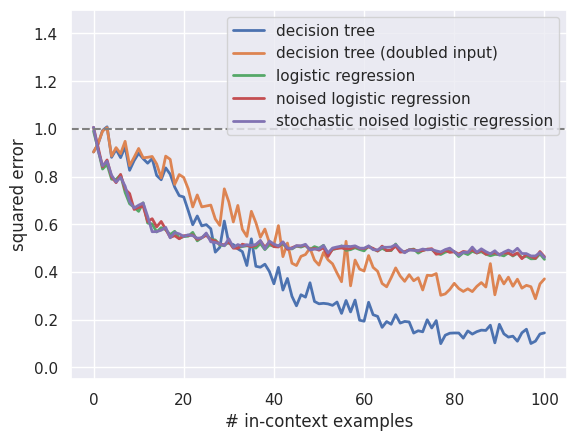

In [ ]:
sparsity = conf_tree.training.task_kwargs.sparsity if "sparsity" in conf_tree.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf_tree.training.task]
plt.plot(loss_tree.mean(axis=0), lw=2, label="decision tree")
plt.plot(loss2_tree.mean(axis=0), lw=2, label="decision tree (doubled input)")
plt.plot(loss_logreg_tree.mean(axis=0) / 0.5, lw=2, label="logistic regression")
plt.plot(loss_logreg_noised_tree.mean(axis=0) / 0.5, lw=2, label="noised logistic regression")
plt.plot(loss_logreg_noised_stochastic_tree.mean(axis=0) / 0.5, lw=2, label="stochastic noised logistic regression")
plt.axhline(baseline, ls="--", color="gray")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.ylim(-0.05, 1.5)  # Replace 0 and 1 with your desired y-axis limits
plt.legend()
plt.show()

# 4. Transformer pretrained on the 2-layer ReLU neural network task
In this section, we are going to achieve the following:

*   Reproduce the experimental results on the ability of the transformer pretrained on the **2-layer ReLU neural network task** to do in-context learning on the lienar regression task
*   Conduct an original experiment to check the ability of the transformer pretrained on the **2-layer ReLU neural network task** to do in-context learning on the logistic regression task under the following three cases
    1.   standard logistic regression task
    2.   noisy logistic regression task
    3.   noisy stochastic logistic regression task

## 4.1 Load the transformer model
We load the transformer model pretrained on the **2-layer ReLU neural network task**
*   n_dims: the dimension of each input is $20$
*   batch_size: the batchsize is $64 \times 10$

In [ ]:
model_tf_2nn, conf_2nn = get_model_from_run(run_path_2nn)

n_dims = conf_2nn.model.n_dims
batch_size = conf_2nn.training.batch_size * 10

## 4.2 Define the task
We define the task used for the pretraining.
*   data_sampler: the sampler to sample the input data $x$
*   task_sampler: the sampler to sample the task data $f(x)$

In [ ]:
data_sampler = get_data_sampler(conf_linear.training.data, n_dims)
task_sampler = get_task_sampler(
    conf_linear.training.task,
    n_dims,\
    batch_size,
    **conf_linear.training.task_kwargs
)
task = task_sampler()

## 4.3 In-context learning the **linear regression task**
We do the following process for each prompt in the batch
* We generate the prompt $P := (x_1, f(x_1), \cdots, x_k, f(x_k), x_{\text{querry}}, f(x_{\text{querry}}))$
  *   xs: the input data $\{x_1, \cdots, x_k, x_{\text{querry}}\}$
  *   ys: the label data $\{f(x_1), \cdots, f(x_k), f(x_{\text{querry}})\}$
  * $x_i, x_{\text{querry}} \overset{iid}{\sim} N(0, I_d) \quad \forall i \in [k]$
  * $f(x) := w^\top x$ where $w \sim N(0, I_d)$
  * $d = 20$ is the dimension of the input $x \in \mathbb{R}^d$
* We obtain the values $M(P^i)$ predicted by the transformer model $M$ given the $i$-th prompt $P^i := (x_1, f(x_1), \cdots, x_i, f(x_i), x_{i + 1})$ for each $i = 0, 1, \cdots, k$
* We compute the loss $\ell(M(P^i), f(x_{i + 1})) = (M(P^i) - f(x_{i + 1}))^2$ for each $i = 0, 1, \cdots, k$

Note that the transformer model we use in this section is pretrained on the following 2-layer ReLU neural network task
* $P := (x_1, f(x_1), \cdots, x_k, f(x_k), x_{\text{querry}}, f(x_{\text{querry}}))$
* $x_i, x_{\text{querry}} \overset{iid}{\sim} N(0, I_d) \quad \forall i \in [k]$
* $f(x) := \alpha^\top g(x)$
  * $\alpha := (\alpha_1, \cdots, \alpha_r)^\top$ where $\alpha_i \overset{iid}{\sim} N(0, 2/r)$ for all $i \in [r]$
  * $g(x) := \left(\text{ReLU}(w_1^\top x), \cdots, \text{ReLU}(w_r^\top x)\right)^\top$ where $w_i \overset{iid}{\sim} N(0, I_d)$ for all $i \in [r]$
  * $\text{ReLU}(x) = \max\{0, x\}$

In [ ]:
xs = data_sampler.sample_xs(b_size=batch_size, n_points=conf_2nn.training.curriculum.points.end)
ys = task.evaluate(xs)

with torch.no_grad():
    pred_2nn = model_tf_2nn(xs, ys)

metric = task.get_metric()
loss_2nn = metric(pred_2nn, ys).numpy()

## 4.4 In-context learning the **linear regression task with doubled input**
We conduct the same process as in 4.3 except for the following where we consider the doubled input
  *   xs2: the input data $\{x_1, \cdots, x_k, x_{\text{querry}}\}$
  *   ys2: the label data $\{f(x_1), \cdots, f(x_k), f(x_{\text{querry}})\}$
  * $x_i, x_{\text{querry}} \overset{iid}{\sim} N(0, 2^2 \cdot I_d) \quad \forall i \in [k]$

In [ ]:
xs2 = 2 * xs
ys2 = task.evaluate(xs2)

with torch.no_grad():
    pred2_2nn = model_tf_2nn(xs2, ys2)

loss2_2nn = metric(pred2_2nn, ys2).numpy()

## 4.5 In-context learning the **decision tree task**
We conduct the same process as in 4.3 except for the following where we consider the logistirc rergession as a task
*   xs_logreg: the input data $\{x_1, \cdots, x_k, x_{\text{querry}}\}$
*   ys_logreg: the label data $\{f(x_1), \cdots, f(x_k), f(x_{\text{querry}})\}$
* $f(x) := 1\left\{\frac{1}{1 + \exp\left[- 1_d^\top x\right]} \ge \frac{1}{2} \right\}$

In [ ]:
xs_logreg = xs
ys_logreg = xs_logreg.sum(axis=2)
ys_logreg = torch.sigmoid(ys_logreg)
ys_logreg = (ys_logreg >= 0.5).float()

with torch.no_grad():
    pred_logreg_2nn = model_tf_2nn(xs_logreg, ys_logreg)

loss_logreg_2nn = metric(pred_logreg_2nn, ys_logreg).numpy()

## 4.6 In-context learning the **noisy logistic regression task**
We conduct the same process as in 4.3 except for the following where we consider the noisy logistirc rergession as a task
*   xs_logreg_noised: the input data $\{x_1, \cdots, x_k, x_{\text{querry}}\}$
*   ys_logreg_noised: the label data $\{f(x_1), \cdots, f(x_k), f(x_{\text{querry}})\}$
* $f(x) := 1\left\{\frac{1}{1 + \exp\left[- 1_d^\top x + \epsilon\right]} \ge \frac{1}{2} \right\}$ where $\epsilon \sim N(0, 1)$

In [ ]:
xs_logreg_noised = xs
ys_logreg_noised = xs_logreg.sum(axis=2)
noise = torch.randn_like(ys_logreg_noised)
ys_logreg_noised = ys_logreg_noised + noise
ys_logreg_noised = torch.sigmoid(ys_logreg_noised)
ys_logreg_noised = (ys_logreg_noised >= 0.5).float()

with torch.no_grad():
    pred_logreg_noised_2nn = model_tf_2nn(xs_logreg_noised, ys_logreg_noised)

loss_logreg_noised_2nn = metric(pred_logreg_noised_2nn, ys_logreg_noised).numpy()

## 4.7 In-context learning the **stochastic noisy logistic regression task**
We conduct the same process as in 4.3 except for the following where we consider the noisy logistirc rergession as a task where the label is sampled from the Bernulli distribution
*   xs_logreg_noised_stochastic: the input data $\{x_1, \cdots, x_k, x_{\text{querry}}\}$
*   ys_logreg_noised_stochastic: the label data $\{f(x_1), \cdots, f(x_k), f(x_{\text{querry}})\}$
* $f(x) \sim \text{Bern}\left(\frac{1}{1 + \exp\left[- 1_d^\top x + \epsilon\right]}\right)$ where $\epsilon \sim N(0, 1)$

In [ ]:
xs_logreg_noised_stochastic = xs
ys_logreg_noised_stochastic = xs_logreg.sum(axis=2)
noise = torch.randn_like(ys_logreg_noised_stochastic)
ys_logreg_noised_stochastic = ys_logreg_noised_stochastic + noise
ys_logreg_noised_stochastic = torch.sigmoid(ys_logreg_noised_stochastic)
ys_logreg_noised_stochastic = torch.bernoulli(ys_logreg_noised_stochastic).float()

with torch.no_grad():
    pred_logreg_noised_stochastic_2nn = model_tf_2nn(xs_logreg_noised_stochastic, ys_logreg_noised_stochastic)

loss_logreg_noised_stochastic_2nn = metric(pred_logreg_noised_stochastic_2nn, ys_logreg_noised_stochastic).numpy()

# 4.8 Visualize the performance of the transformer's in-context learning ability
Interpretation of the results
*   The in-context learning ability to do a linear regression task of the transformer model pretrained on the 2-layer ReLU neural network task is affected by the scale of the input, incursing almost constant additional prediction error for a given number of the in-context examples after the model reachs the error $1/2$
* The transformer model pretrained on the 2-layer ReLU neural network task performs an in-context learning for a logistic regression task probably due to the complex task it is trained on, but the performance is worse compared to the linear regression task.

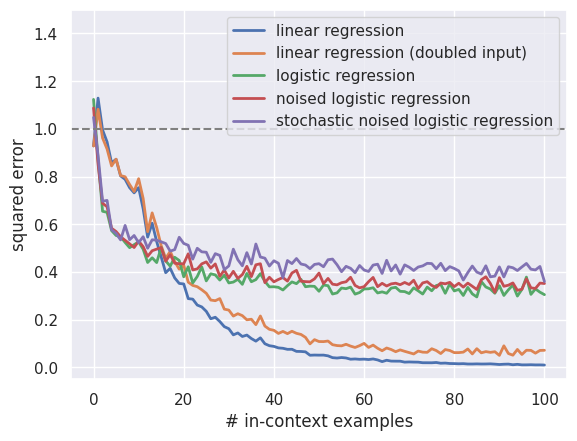

In [ ]:
sparsity = conf_2nn.training.task_kwargs.sparsity if "sparsity" in conf_2nn.training.task_kwargs else None
baseline = {
    "linear_regression": n_dims,
    "sparse_linear_regression": sparsity,
    "relu_2nn_regression": n_dims,
    "decision_tree": 1,
}[conf_2nn.training.task]
plt.plot(loss_2nn.mean(axis=0) / n_dims, lw=2, label="linear regression")
plt.plot(loss2_2nn.mean(axis=0) / 4 / n_dims, lw=2, label="linear regression (doubled input)")
plt.plot(loss_logreg_2nn.mean(axis=0) / 0.5, lw=2, label="logistic regression")
plt.plot(loss_logreg_noised_2nn.mean(axis=0) / 0.5, lw=2, label="noised logistic regression")
plt.plot(loss_logreg_noised_stochastic_2nn.mean(axis=0) / 0.5, lw=2, label="stochastic noised logistic regression")
plt.axhline(baseline / n_dims, ls="--", color="gray")
plt.xlabel("# in-context examples")
plt.ylabel("squared error")
plt.ylim(-0.05, 1.5)  # Replace 0 and 1 with your desired y-axis limits
plt.legend()
plt.show()